# Optuna Hyperparameter Tuning 

In [2]:
import pandas as pd
import numpy as np
import json
import os
import pickle
import warnings
from datetime import datetime
from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV

import lightgbm as lgb
import optuna
from optuna.samplers import TPESampler

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

RANDOM_STATE = 42

print(f"Optuna version: {optuna.__version__}")
print(f"LightGBM version: {lgb.__version__}")

c:\Users\vitus\Desktop\master\master_project\chess-app\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Optuna version: 4.6.0
LightGBM version: 4.6.0


## 1. Configuration

In [3]:
CONFIG = {
    # Paths
    'data_dir': 'bucket_data',
    'model_dir': 'models',
    'output_model': 'models/global_model_optimized.pkl',
    
    # Optuna
    'n_trials': 100,
    'timeout': 3600,  
    'cv_folds': 5,
    
    # Training
    'test_size': 0.2,
    'random_state': RANDOM_STATE
}

print("Configuration:")
print(f"  Trials: {CONFIG['n_trials']}")
print(f"  Timeout: {CONFIG['timeout']}s ({CONFIG['timeout']//60} min)")
print(f"  CV Folds: {CONFIG['cv_folds']}")

Configuration:
  Trials: 100
  Timeout: 3600s (60 min)
  CV Folds: 5


## 2. Load Data

In [4]:
FEATURE_COLUMNS = [
    # Rating
    'rating_diff', 'elo_expected',
    
    # Player features
    'form_5_adj', 'form_10_adj', 'form_20_adj',
    'streak_norm', 'time_management', 'time_trouble_rate',
    'is_white', 'color_advantage',
    'rating_trend_norm', 'residual_ma10', 'avg_game_length',
    'eco_A_wr', 'eco_B_wr', 'eco_C_wr', 'eco_D_wr', 'eco_E_wr',
    
    # Opponent features
    'opp_form_5_adj', 'opp_form_10_adj', 'opp_streak_norm',
    'opp_time_management', 'opp_rating_trend_norm', 'opp_residual_ma10',
    'has_opponent_data',
    
    # Difference features
    'form_5_diff', 'form_10_diff', 'streak_diff',
    'time_mgmt_diff', 'residual_diff'
]

TARGET_COLUMN = 'outcome_binary'

print(f"Features: {len(FEATURE_COLUMNS)}")

Features: 30


In [5]:
# Load existing global model to get baseline metrics
baseline_model_path = os.path.join(CONFIG['model_dir'], 'global_model.pkl')

if os.path.exists(baseline_model_path):
    with open(baseline_model_path, 'rb') as f:
        baseline_package = pickle.load(f)
    print(f"Baseline model loaded")
    print(f"  AUC: {baseline_package['metrics']['model_auc']:.4f}")
    print(f"  Accuracy: {baseline_package['metrics']['accuracy']:.4f}")
else:
    print("Warning: No baseline model found")
    baseline_package = None

Baseline model loaded
  AUC: 0.6049
  Accuracy: 0.5697


In [6]:
from datetime import datetime

def load_bucket_data(bucket_name, data_dir):
    safe_name = bucket_name.replace('+', '_plus')
    file_path = os.path.join(data_dir, f"bucket_{safe_name}_games.json")
    if not os.path.exists(file_path):
        return None
    with open(file_path, 'r') as f:
        return json.load(f)

def parse_games_to_df(games_dict, bucket_name):
    rows = []
    for username, games in games_dict.items():
        for game in games:
            try:
                players = game.get('players', {})
                white_info = players.get('white', {})
                black_info = players.get('black', {})
                
                white_user = white_info.get('user', {}).get('name', '').lower()
                black_user = black_info.get('user', {}).get('name', '').lower()
                
                is_white = white_user == username.lower()
                player_color = 'white' if is_white else 'black'
                
                player_info = white_info if is_white else black_info
                opponent_info = black_info if is_white else white_info
                
                player_rating = player_info.get('rating')
                opponent_rating = opponent_info.get('rating')
                opponent_username = opponent_info.get('user', {}).get('name', '')
                
                if not player_rating or not opponent_rating:
                    continue
                
                winner = game.get('winner')
                if winner == player_color:
                    outcome_numeric = 1.0
                    outcome_binary = 1
                elif winner is None:
                    outcome_numeric = 0.5
                    outcome_binary = 0
                else:
                    outcome_numeric = 0.0
                    outcome_binary = 0
                
                clocks = game.get('clocks', [])
                time_trouble = 0
                avg_time_per_move = None
                
                if clocks:
                    player_clocks = []
                    for idx, clock in enumerate(clocks):
                        if (idx % 2 == 0 and is_white) or (idx % 2 == 1 and not is_white):
                            player_clocks.append(clock / 100)
                    if player_clocks:
                        time_trouble = 1 if min(player_clocks) < 30 else 0
                
                opening = game.get('opening', {})
                eco_category = opening.get('eco', 'A00')[0] if opening.get('eco') else 'A'
                
                moves_str = game.get('moves', '')
                num_moves = len(moves_str.split()) // 2 if moves_str else 0
                
                created_at = game.get('createdAt', 0)
                game_date = datetime.fromtimestamp(created_at / 1000) if created_at else None
                
                rows.append({
                    'bucket': bucket_name,
                    'date': game_date,
                    'game_id': game.get('id', ''),
                    'player_username': username.lower(),
                    'opponent_username': opponent_username.lower() if opponent_username else '',
                    'player_color': player_color,
                    'player_rating': player_rating,
                    'opponent_rating': opponent_rating,
                    'rating_diff': opponent_rating - player_rating,
                    'outcome_numeric': outcome_numeric,
                    'outcome_binary': outcome_binary,
                    'eco_category': eco_category,
                    'num_moves': num_moves,
                    'time_trouble': time_trouble
                })
            except:
                continue
    return pd.DataFrame(rows)

print("Data loading functions defined")

Data loading functions defined


In [7]:
# Feature engineering functions
def calculate_elo_expected(rating_diff):
    return 1 / (1 + 10 ** (rating_diff / 400))

def exponential_weighted_mean(values, decay_rate=0.15):
    n = len(values)
    if n == 0:
        return 0.5
    weights = np.exp(-decay_rate * np.arange(n))
    weights = weights / weights.sum()
    return np.sum(values * weights)

def calculate_player_features(df, decay_rate=0.15):
    df = df.copy()
    
    def weighted_form(series, window):
        result = []
        for i in range(len(series)):
            if i < 1:
                result.append(0.5)
            else:
                start = max(0, i - window)
                vals = series.iloc[start:i].values
                if len(vals) > 0:
                    result.append(exponential_weighted_mean(vals[::-1], decay_rate))
                else:
                    result.append(0.5)
        return result
    
    df['form_5'] = weighted_form(df['outcome_numeric'], 5)
    df['form_10'] = weighted_form(df['outcome_numeric'], 10)
    df['form_20'] = weighted_form(df['outcome_numeric'], 20)
    
    streaks = []
    streak = 0
    for outcome in df['outcome_numeric']:
        streaks.append(streak)
        if outcome == 1:
            streak = streak + 1 if streak >= 0 else 1
        elif outcome == 0:
            streak = streak - 1 if streak <= 0 else -1
        else:
            streak = 0
    df['streak'] = streaks
    
    df['time_trouble_rate'] = weighted_form(df['time_trouble'], 20)
    
    df['white_wr'] = df[df['player_color'] == 'white']['outcome_numeric'].expanding().mean().reindex(df.index).ffill().shift(1).fillna(0.5)
    df['black_wr'] = df[df['player_color'] == 'black']['outcome_numeric'].expanding().mean().reindex(df.index).ffill().shift(1).fillna(0.5)
    
    df['games_played'] = range(len(df))
    df['rating_trend'] = df['player_rating'].diff(periods=20).shift(1).fillna(0)
    df['avg_game_length'] = df['num_moves'].rolling(window=20, min_periods=1).mean().shift(1).fillna(30)
    
    for eco_cat in ['A', 'B', 'C', 'D', 'E']:
        eco_games = df[df['eco_category'] == eco_cat]['outcome_numeric']
        df[f'eco_{eco_cat}_wr'] = eco_games.expanding().mean().reindex(df.index).ffill().shift(1).fillna(0.5)
    
    df['elo_expected'] = df['rating_diff'].apply(calculate_elo_expected)
    df['residual'] = df['outcome_numeric'] - df['elo_expected']
    df['residual_ma10'] = df['residual'].rolling(window=10, min_periods=1).mean().shift(1).fillna(0)
    
    return df

def engineer_features_for_bucket(df, decay_rate=0.15, min_games=10):
    processed_dfs = []
    for username, player_df in df.groupby('player_username'):
        player_df = player_df.sort_values('date').reset_index(drop=True)
        processed = calculate_player_features(player_df, decay_rate)
        processed_dfs.append(processed)
    if not processed_dfs:
        return pd.DataFrame()
    df_features = pd.concat(processed_dfs, ignore_index=True)
    df_features = df_features[df_features['games_played'] >= min_games]
    return df_features

def add_opponent_features(df):
    feature_cols = ['form_5', 'form_10', 'form_20', 'streak', 'time_trouble_rate',
                    'white_wr', 'black_wr', 'rating_trend', 'residual_ma10', 'games_played']
    
    lookup = {}
    for _, row in df.iterrows():
        key = (row['player_username'], row['game_id'])
        lookup[key] = {col: row[col] for col in feature_cols}
    
    opp_data = []
    for _, row in df.iterrows():
        key = (row['opponent_username'], row['game_id'])
        if key in lookup:
            opp = lookup[key]
            opp_data.append({
                'opp_form_5': opp['form_5'], 'opp_form_10': opp['form_10'],
                'opp_streak': opp['streak'], 'opp_time_trouble_rate': opp['time_trouble_rate'],
                'opp_rating_trend': opp['rating_trend'], 'opp_residual_ma10': opp['residual_ma10'],
                'has_opponent_data': 1
            })
        else:
            opp_data.append({
                'opp_form_5': 0.5, 'opp_form_10': 0.5, 'opp_streak': 0,
                'opp_time_trouble_rate': 0.33, 'opp_rating_trend': 0,
                'opp_residual_ma10': 0, 'has_opponent_data': 0
            })
    
    return pd.concat([df.reset_index(drop=True), pd.DataFrame(opp_data)], axis=1)

def create_model_features(df):
    df = df.copy()
    df['elo_expected'] = df['rating_diff'].apply(calculate_elo_expected)
    df['form_5_adj'] = df['form_5'] - 0.5
    df['form_10_adj'] = df['form_10'] - 0.5
    df['form_20_adj'] = df['form_20'] - 0.5
    df['streak_norm'] = df['streak'] / 10
    df['time_management'] = 1 - df['time_trouble_rate']
    df['is_white'] = (df['player_color'] == 'white').astype(int)
    df['color_advantage'] = df.apply(lambda r: r['white_wr'] - 0.5 if r['is_white'] == 1 else r['black_wr'] - 0.5, axis=1)
    df['rating_trend_norm'] = df['rating_trend'] / 100
    df['opp_form_5_adj'] = df['opp_form_5'] - 0.5
    df['opp_form_10_adj'] = df['opp_form_10'] - 0.5
    df['opp_streak_norm'] = df['opp_streak'] / 10
    df['opp_time_management'] = 1 - df['opp_time_trouble_rate']
    df['opp_rating_trend_norm'] = df['opp_rating_trend'] / 100
    df['form_5_diff'] = df['form_5_adj'] - df['opp_form_5_adj']
    df['form_10_diff'] = df['form_10_adj'] - df['opp_form_10_adj']
    df['streak_diff'] = df['streak_norm'] - df['opp_streak_norm']
    df['time_mgmt_diff'] = df['time_management'] - df['opp_time_management']
    df['residual_diff'] = df['residual_ma10'] - df['opp_residual_ma10']
    return df

print("Feature engineering functions defined")

Feature engineering functions defined


In [8]:
# Load all bucket data
BUCKETS = ['800-1000', '1000-1200', '1200-1400', '1400-1600', '1600-1800',
           '1800-2000', '2000-2200', '2200-2400', '2400+']

all_dfs = []

print("Loading and processing buckets...")
for bucket in tqdm(BUCKETS):
    raw = load_bucket_data(bucket, CONFIG['data_dir'])
    if raw:
        df = parse_games_to_df(raw, bucket)
        df_feat = engineer_features_for_bucket(df)
        if len(df_feat) > 0:
            df_feat = add_opponent_features(df_feat)
            df_feat = create_model_features(df_feat)
            all_dfs.append(df_feat)

df_combined = pd.concat(all_dfs, ignore_index=True)
df_combined = df_combined.dropna(subset=FEATURE_COLUMNS + [TARGET_COLUMN])

print(f"\nTotal samples: {len(df_combined):,}")

Loading and processing buckets...


100%|██████████| 9/9 [02:30<00:00, 16.67s/it]



Total samples: 587,861


In [9]:
# Prepare train/test split
X = df_combined[FEATURE_COLUMNS].values
y = df_combined[TARGET_COLUMN].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state'],
    stratify=y
)

print(f"Training set: {len(X_train):,}")
print(f"Test set: {len(X_test):,}")

Training set: 470,288
Test set: 117,573


## 3. Baseline Performance

In [10]:
# ELO baseline
elo_idx = FEATURE_COLUMNS.index('elo_expected')
y_pred_elo = X_test[:, elo_idx]
elo_auc = roc_auc_score(y_test, y_pred_elo)

print(f"ELO Baseline AUC: {elo_auc:.4f}")

ELO Baseline AUC: 0.5987


In [11]:
# Current model baseline (before tuning)
baseline_lgb = lgb.LGBMClassifier(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.08,
    num_leaves=31,
    min_child_samples=30,
    reg_alpha=0.1,
    reg_lambda=0.1,
    importance_type='gain',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

baseline_lgb.fit(X_train, y_train)
y_pred_baseline = baseline_lgb.predict_proba(X_test)[:, 1]
baseline_auc = roc_auc_score(y_test, y_pred_baseline)

print(f"Baseline LightGBM AUC: {baseline_auc:.4f}")
print(f"Improvement over ELO: {(baseline_auc - elo_auc)*100:+.2f}%")

Baseline LightGBM AUC: 0.6045
Improvement over ELO: +0.58%


## 4. Optuna Optimization

In [12]:
def objective(trial):
    """
    Optuna objective function for LightGBM.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 127),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        
        'importance_type': 'gain',
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'verbose': -1
    }
    
    cv = StratifiedKFold(n_splits=CONFIG['cv_folds'], shuffle=True, random_state=RANDOM_STATE)
    model = lgb.LGBMClassifier(**params)
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    
    return scores.mean()

In [13]:
# Create and run study
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_STATE),
    study_name='lgbm_global_model'
)

print(f"Starting optimization...")
print(f"  Trials: {CONFIG['n_trials']}")
print(f"  Timeout: {CONFIG['timeout']}s")
print()

# Progress callback
def callback(study, trial):
    if trial.number % 10 == 0:
        print(f"Trial {trial.number:3d}: AUC = {trial.value:.4f} | Best = {study.best_value:.4f}")

study.optimize(
    objective,
    n_trials=CONFIG['n_trials'],
    timeout=CONFIG['timeout'],
    callbacks=[callback],
    show_progress_bar=True
)

print(f"\nOptimization complete!")
print(f"  Best trial: {study.best_trial.number}")
print(f"  Best CV AUC: {study.best_value:.4f}")

Starting optimization...
  Trials: 100
  Timeout: 3600s



Best trial: 0. Best value: 0.603286:   1%|          | 1/100 [00:17<28:06, 17.04s/it, 17.04/3600 seconds]

Trial   0: AUC = 0.6033 | Best = 0.6033


Best trial: 8. Best value: 0.606286:  11%|█         | 11/100 [03:40<33:37, 22.67s/it, 220.35/3600 seconds]

Trial  10: AUC = 0.6058 | Best = 0.6063


Best trial: 8. Best value: 0.606286:  21%|██        | 21/100 [08:16<31:58, 24.29s/it, 496.39/3600 seconds]

Trial  20: AUC = 0.6061 | Best = 0.6063


Best trial: 8. Best value: 0.606286:  31%|███       | 31/100 [12:37<29:44, 25.86s/it, 757.48/3600 seconds]

Trial  30: AUC = 0.6053 | Best = 0.6063


Best trial: 8. Best value: 0.606286:  41%|████      | 41/100 [17:57<33:52, 34.45s/it, 1077.69/3600 seconds]

Trial  40: AUC = 0.6054 | Best = 0.6063


Best trial: 8. Best value: 0.606286:  51%|█████     | 51/100 [22:55<26:07, 31.98s/it, 1375.20/3600 seconds]

Trial  50: AUC = 0.6059 | Best = 0.6063


Best trial: 8. Best value: 0.606286:  61%|██████    | 61/100 [27:26<14:19, 22.03s/it, 1646.34/3600 seconds]

Trial  60: AUC = 0.6053 | Best = 0.6063


Best trial: 8. Best value: 0.606286:  71%|███████   | 71/100 [32:44<15:15, 31.56s/it, 1964.73/3600 seconds]

Trial  70: AUC = 0.6057 | Best = 0.6063


Best trial: 8. Best value: 0.606286:  81%|████████  | 81/100 [36:49<07:17, 23.03s/it, 2209.16/3600 seconds]

Trial  80: AUC = 0.6061 | Best = 0.6063


Best trial: 8. Best value: 0.606286:  91%|█████████ | 91/100 [41:25<04:13, 28.17s/it, 2485.71/3600 seconds]

Trial  90: AUC = 0.6062 | Best = 0.6063


Best trial: 8. Best value: 0.606286: 100%|██████████| 100/100 [46:17<00:00, 27.77s/it, 2777.15/3600 seconds]


Optimization complete!
  Best trial: 8
  Best CV AUC: 0.6063


## 5. Results Analysis

In [14]:
# Best parameters
print("Best Parameters:")
print("-" * 40)
for key, value in study.best_params.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.6f}")
    else:
        print(f"  {key}: {value}")

Best Parameters:
----------------------------------------
  n_estimators: 446
  max_depth: 9
  learning_rate: 0.026947
  num_leaves: 22
  min_child_samples: 38
  reg_alpha: 0.000008
  reg_lambda: 0.036852
  subsample: 0.818779
  colsample_bytree: 0.943606
  min_split_gain: 0.472215


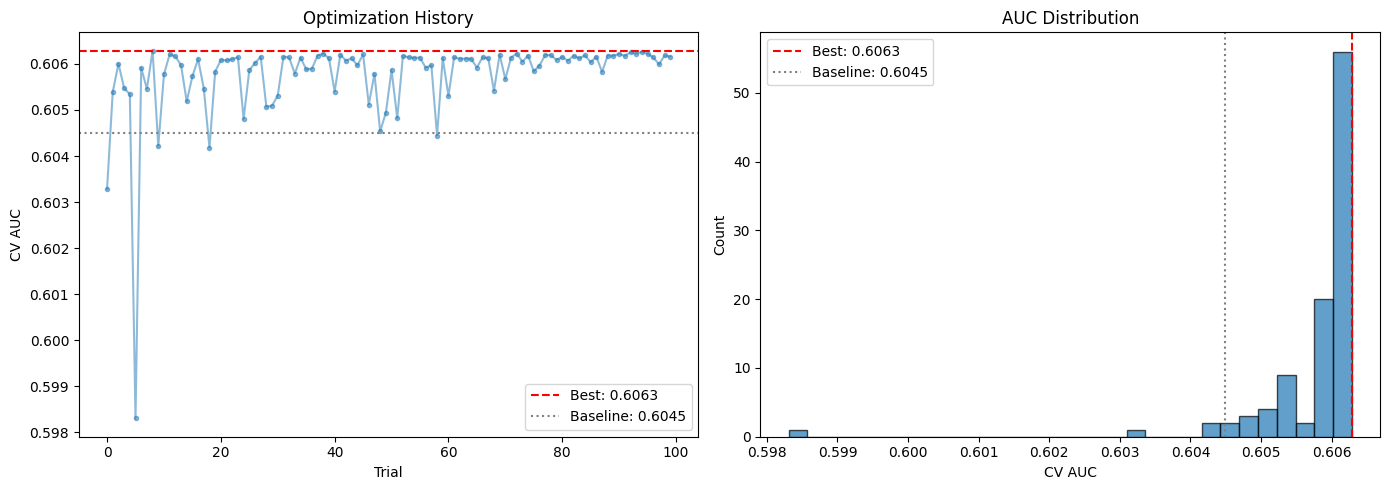

In [15]:
# Optimization history
trials_df = study.trials_dataframe()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AUC over trials
axes[0].plot(trials_df['number'], trials_df['value'], 'o-', alpha=0.5, markersize=3)
axes[0].axhline(y=study.best_value, color='r', linestyle='--', label=f'Best: {study.best_value:.4f}')
axes[0].axhline(y=baseline_auc, color='gray', linestyle=':', label=f'Baseline: {baseline_auc:.4f}')
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('CV AUC')
axes[0].set_title('Optimization History')
axes[0].legend()

# AUC distribution
axes[1].hist(trials_df['value'], bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=study.best_value, color='r', linestyle='--', label=f'Best: {study.best_value:.4f}')
axes[1].axvline(x=baseline_auc, color='gray', linestyle=':', label=f'Baseline: {baseline_auc:.4f}')
axes[1].set_xlabel('CV AUC')
axes[1].set_ylabel('Count')
axes[1].set_title('AUC Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

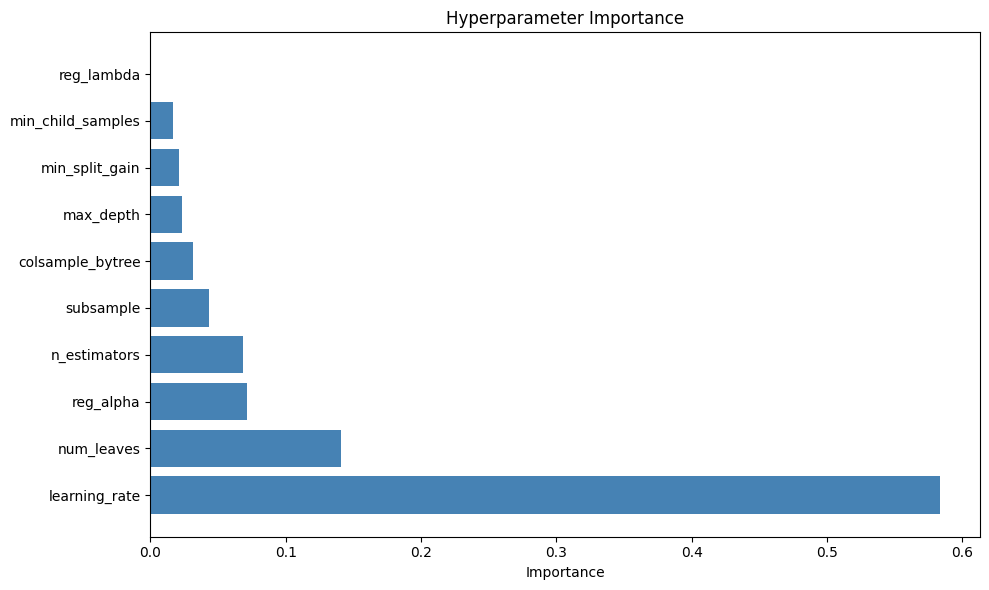

In [16]:
# Parameter importance
try:
    importance = optuna.importance.get_param_importances(study)
    
    plt.figure(figsize=(10, 6))
    params = list(importance.keys())
    values = list(importance.values())
    
    plt.barh(params, values, color='steelblue')
    plt.xlabel('Importance')
    plt.title('Hyperparameter Importance')
    plt.tight_layout()
    plt.show()
except:
    print("Could not calculate parameter importance (need more trials)")

## 6. Train Final Model

In [17]:
# Train with best parameters
best_params = study.best_params.copy()
best_params['importance_type'] = 'gain'
best_params['random_state'] = RANDOM_STATE
best_params['n_jobs'] = -1
best_params['verbose'] = -1

optimized_model = lgb.LGBMClassifier(**best_params)
optimized_model.fit(X_train, y_train)

# Evaluate
y_pred_optimized = optimized_model.predict_proba(X_test)[:, 1]
optimized_auc = roc_auc_score(y_test, y_pred_optimized)
optimized_acc = accuracy_score(y_test, (y_pred_optimized > 0.5).astype(int))

print(f"Optimized Model (before calibration):")
print(f"  AUC: {optimized_auc:.4f}")
print(f"  Accuracy: {optimized_acc:.4f}")

Optimized Model (before calibration):
  AUC: 0.6051
  Accuracy: 0.5705


In [18]:
# Calibrate
calibrated_model = CalibratedClassifierCV(optimized_model, method='isotonic', cv=5)
calibrated_model.fit(X_train, y_train)

y_pred_calibrated = calibrated_model.predict_proba(X_test)[:, 1]
calibrated_auc = roc_auc_score(y_test, y_pred_calibrated)
calibrated_acc = accuracy_score(y_test, (y_pred_calibrated > 0.5).astype(int))
calibrated_brier = brier_score_loss(y_test, y_pred_calibrated)

print(f"Calibrated Model:")
print(f"  AUC: {calibrated_auc:.4f}")
print(f"  Accuracy: {calibrated_acc:.4f}")
print(f"  Brier Score: {calibrated_brier:.4f}")

Calibrated Model:
  AUC: 0.6050
  Accuracy: 0.5702
  Brier Score: 0.2383


## 7. Comparison

In [19]:
# Summary comparison
print("COMPARISON SUMMARY")

print(f"\n{'Model':<25} {'AUC':>10} {'vs ELO':>12}")
print("-" * 50)
print(f"{'ELO Baseline':<25} {elo_auc:>10.4f} {'-':>12}")
print(f"{'LightGBM (default)':<25} {baseline_auc:>10.4f} {(baseline_auc-elo_auc)*100:>+11.2f}%")
print(f"{'LightGBM (optimized)':<25} {calibrated_auc:>10.4f} {(calibrated_auc-elo_auc)*100:>+11.2f}%")
print("-" * 50)
print(f"\nImprovement from tuning: {(calibrated_auc-baseline_auc)*100:+.2f}%")

COMPARISON SUMMARY

Model                            AUC       vs ELO
--------------------------------------------------
ELO Baseline                  0.5987            -
LightGBM (default)            0.6045       +0.58%
LightGBM (optimized)          0.6050       +0.63%
--------------------------------------------------

Improvement from tuning: +0.05%


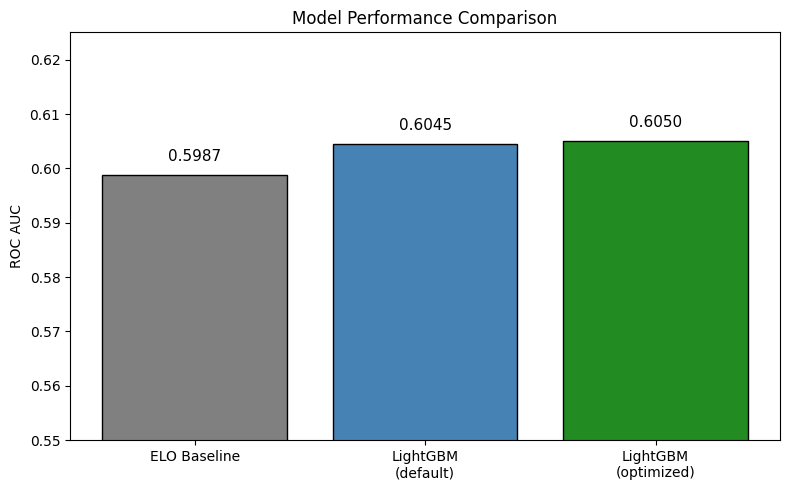

In [20]:
# Visual comparison
models = ['ELO Baseline', 'LightGBM\n(default)', 'LightGBM\n(optimized)']
aucs = [elo_auc, baseline_auc, calibrated_auc]
colors = ['gray', 'steelblue', 'forestgreen']

plt.figure(figsize=(8, 5))
bars = plt.bar(models, aucs, color=colors, edgecolor='black')

# Add value labels
for bar, auc in zip(bars, aucs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{auc:.4f}', ha='center', va='bottom', fontsize=11)

plt.ylabel('ROC AUC')
plt.title('Model Performance Comparison')
plt.ylim(0.55, max(aucs) + 0.02)
plt.tight_layout()
plt.show()

## 8. Save Optimized Model

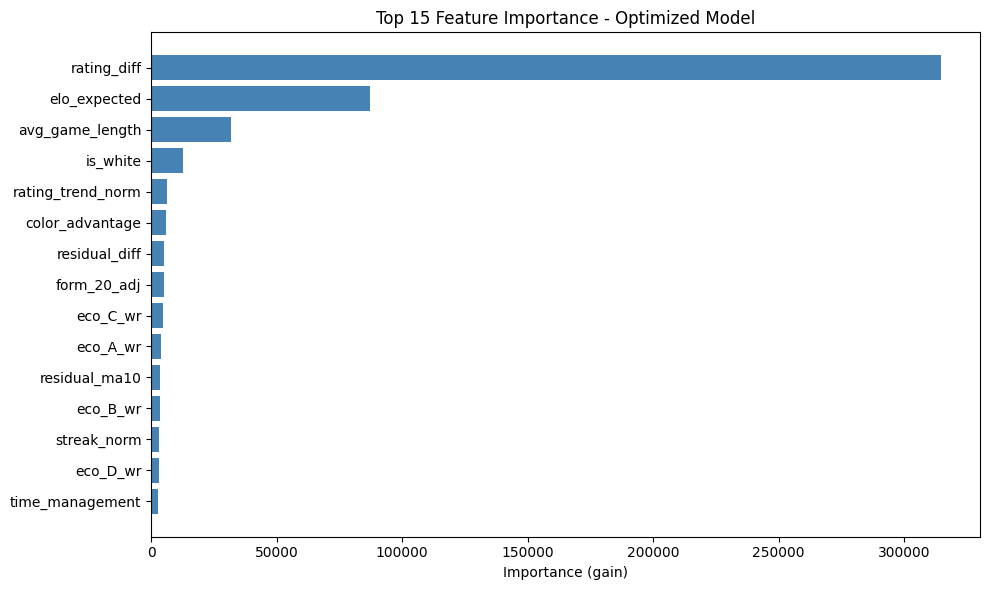

In [21]:
# Feature importance
feature_importance = dict(zip(FEATURE_COLUMNS, optimized_model.feature_importances_))

# Plot top 15
importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
}).sort_values('importance', ascending=True).tail(15)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
plt.xlabel('Importance (gain)')
plt.title('Top 15 Feature Importance - Optimized Model')
plt.tight_layout()
plt.show()

In [22]:
# Save model package
model_package = {
    'model': calibrated_model,
    'base_model': optimized_model,
    'feature_columns': FEATURE_COLUMNS,
    'best_params': best_params,
    'metrics': {
        'elo_auc': elo_auc,
        'baseline_auc': baseline_auc,
        'optimized_auc': calibrated_auc,
        'accuracy': calibrated_acc,
        'brier_score': calibrated_brier,
        'improvement_vs_baseline': (calibrated_auc - baseline_auc) * 100,
        'improvement_vs_elo': (calibrated_auc - elo_auc) * 100
    },
    'feature_importance': feature_importance,
    'optimization': {
        'n_trials': len(study.trials),
        'best_trial': study.best_trial.number,
        'best_cv_auc': study.best_value
    },
    'training_date': datetime.now().isoformat()
}

with open(CONFIG['output_model'], 'wb') as f:
    pickle.dump(model_package, f)

print(f"Model saved to: {CONFIG['output_model']}")
print(f"File size: {os.path.getsize(CONFIG['output_model']) / (1024*1024):.2f} MB")

Model saved to: models/global_model_optimized.pkl
File size: 6.53 MB


In [23]:
# Save best params separately for reference
params_file = 'models/best_params.json'

# Convert numpy types to Python types for JSON
params_json = {k: float(v) if isinstance(v, (np.floating, float)) else int(v) if isinstance(v, (np.integer, int)) else v 
               for k, v in best_params.items()}

with open(params_file, 'w') as f:
    json.dump(params_json, f, indent=2)

print(f"Best params saved to: {params_file}")

Best params saved to: models/best_params.json


## 9. Final Summary

In [24]:
print("OPTUNA OPTIMIZATION COMPLETE")

print(f"\nTrials: {len(study.trials)}")
print(f"Best trial: #{study.best_trial.number}")

print(f"\nPerformance:")
print(f"  ELO Baseline:       {elo_auc:.4f}")
print(f"  Before tuning:      {baseline_auc:.4f} ({(baseline_auc-elo_auc)*100:+.2f}% vs ELO)")
print(f"  After tuning:       {calibrated_auc:.4f} ({(calibrated_auc-elo_auc)*100:+.2f}% vs ELO)")
print(f"  Tuning improvement: {(calibrated_auc-baseline_auc)*100:+.2f}%")

print(f"\nFiles saved:")
print(f"  {CONFIG['output_model']}")
print(f"  models/best_params.json")

print("\n" + "=" * 60)

OPTUNA OPTIMIZATION COMPLETE

Trials: 100
Best trial: #8

Performance:
  ELO Baseline:       0.5987
  Before tuning:      0.6045 (+0.58% vs ELO)
  After tuning:       0.6050 (+0.63% vs ELO)
  Tuning improvement: +0.05%

Files saved:
  models/global_model_optimized.pkl
  models/best_params.json

